# Data preprocessing: Jane Street 2020

Using MLP to classify, the focus here is to establish the workflow and testing submission.

Some issues observed:
 - NaN filling scheme herein drops ~ 10% rows. This may be too many, and warrants rethinking


## 0. Load data

In [2]:
!conda info --envs

# conda environments:
#
base                  *  /home/AWC/wang/anaconda3
tf                       /home/AWC/wang/anaconda3/envs/tf



In [191]:
import os, sys
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dtable
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.style.use('dark_background') #plt.style.use('default')

globalSeed=67
np.random.seed(globalSeed) # for reproducibility

# PyTorch
import torch

# TensorFlow
# import tensorflow as tf
# print(f'tensorflow version: {tf.__version__}')
# print(tf.config.list_physical_devices('GPU'))
# from tensorflow import keras
# from tensorflow.keras import layers

# from tabulate import tabulate
# pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

pd.set_option('display.max_columns', 200)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
# # Suppressing warning before saving the presentation, only
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
%%time
ddir='~/learn/kaggle/Data/JaneStreet20' # local
#ddir='../input/jane-street-market-prediction' # kaggle

# using datatable for faster loading
data = dtable.fread(os.path.join(ddir,"train.csv")).to_pandas()
features = pd.read_csv(os.path.join(ddir,"features.csv"))

gc.collect();

CPU times: user 41.7 s, sys: 3.46 s, total: 45.1 s
Wall time: 4.01 s


0

## 1.  Preprecessing

The data may be used in later sections are
 - data_t, data_v, data_c for TVT data
 - nFeat
 - norm, for normalization


#### 1.1.1 Test on one day data: no need to run

In [118]:
# Apply fill
spanFillNa=3 # EMA span to fill nan
data_1=data.loc[data['date']==0]
nFeat=130
featName=[f'feature_{ii}' for ii in range(nFeat)]
fillCol=[f'feature_{ii}' for ii in range(nFeat) if ii not in [0,64]] # features to fill nan
data_1_=data_1[fillCol].ewm(span=spanFillNa).mean()
data_1_fill=data_1.copy()
for cname in fillCol:
    toFill=data_1[cname].isna()
    data_1_fill.loc[toFill,cname]=data_1_.loc[toFill,cname]


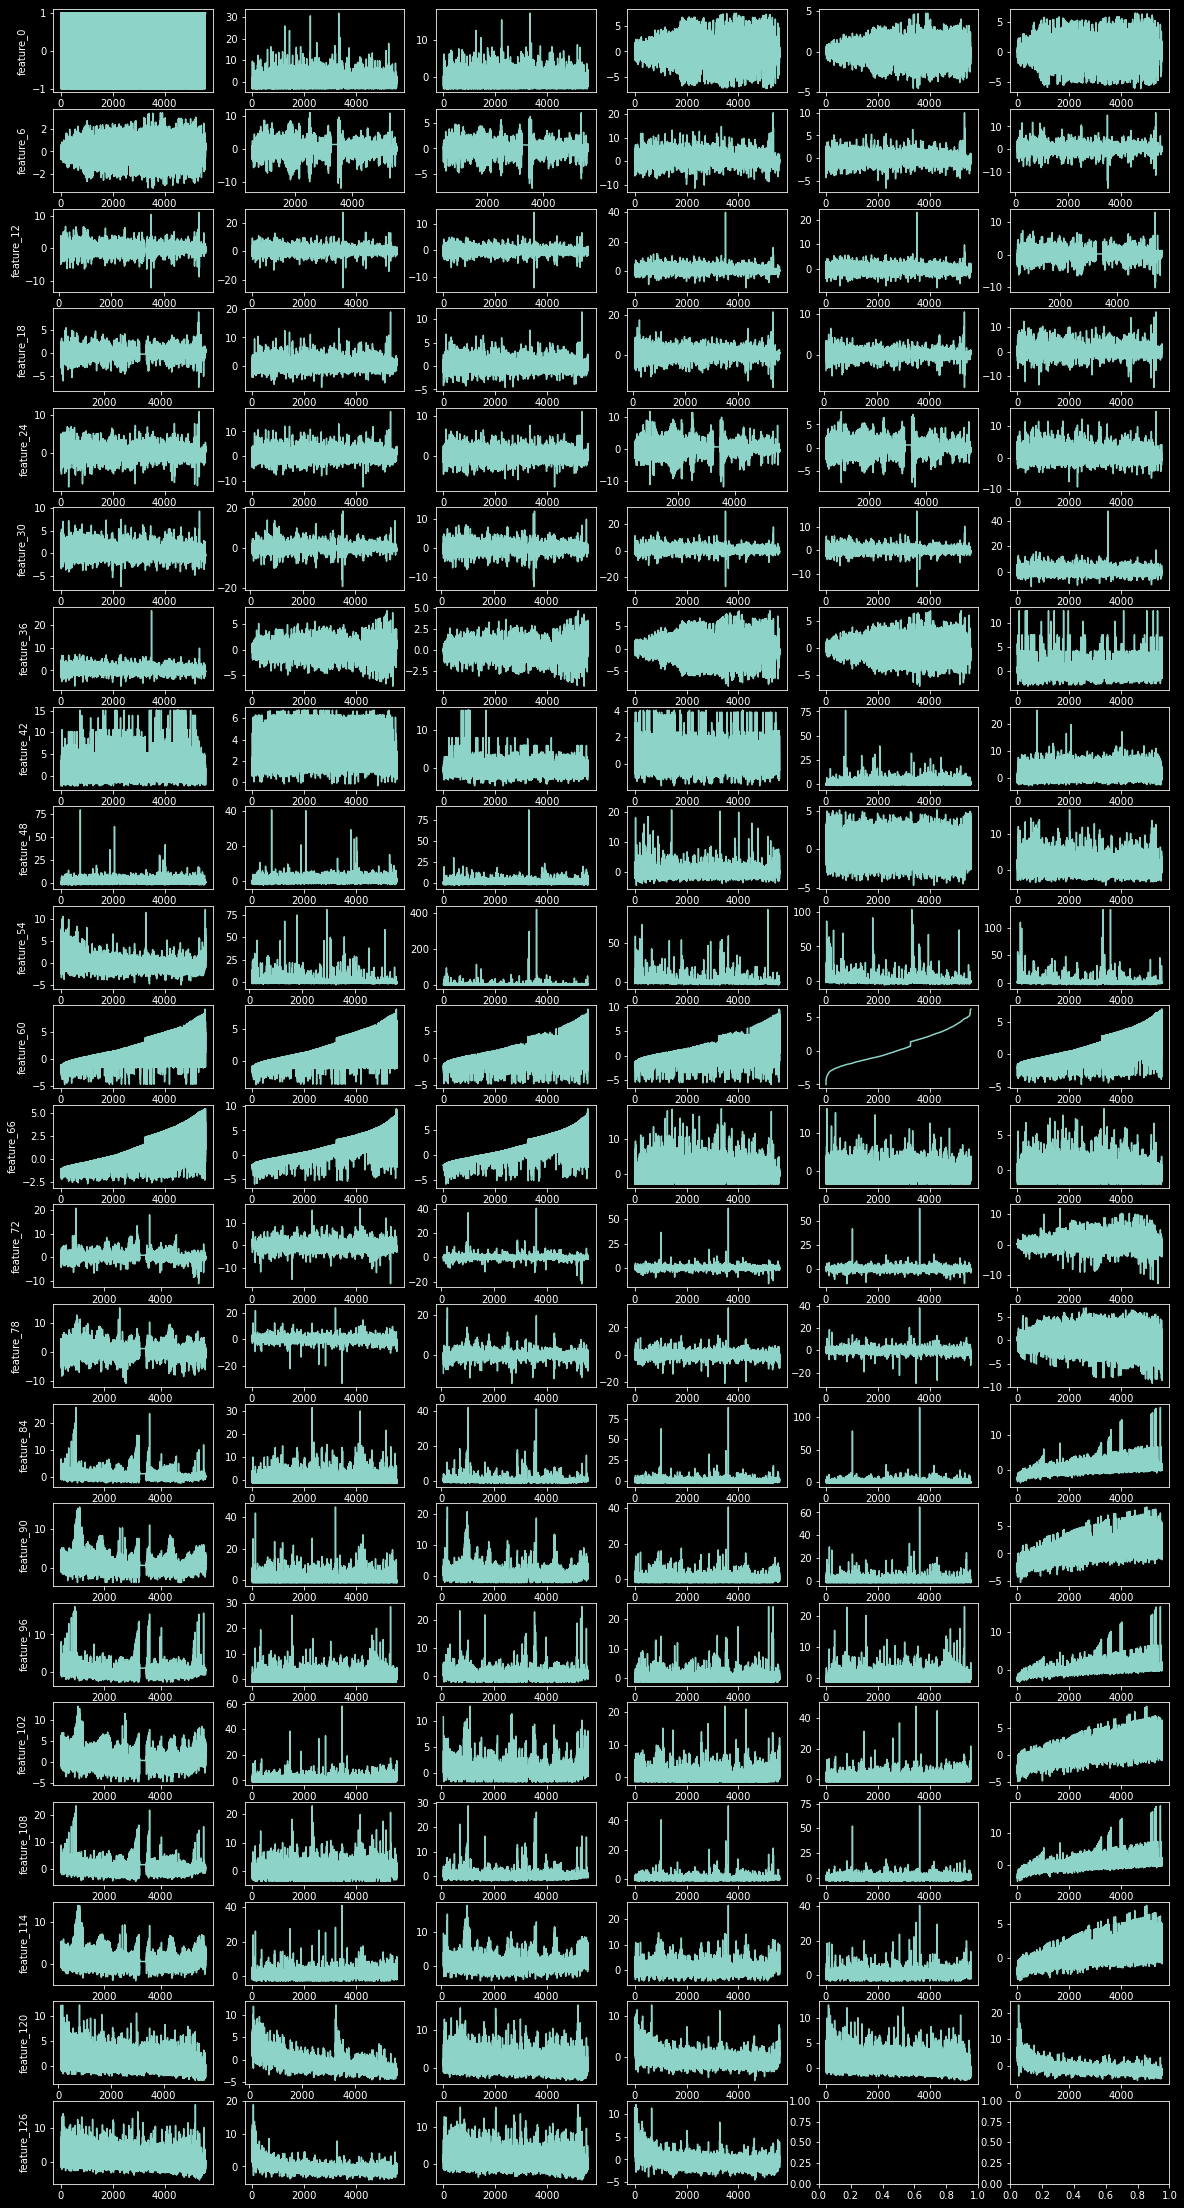

In [68]:
# Overview plot
idxSet=range(3000,4000)
fig, axs = plt.subplots(nrows=int(nFeat/6)+1, ncols=6,figsize=(20, 40)) # 
for ii,cname in enumerate(featName):
    ax=axs[ii//6,ii%6]
    ax.plot(data_1['ts_id'],data_1_fill[cname])
    if ii%6==0:
        ax.set(ylabel=cname)

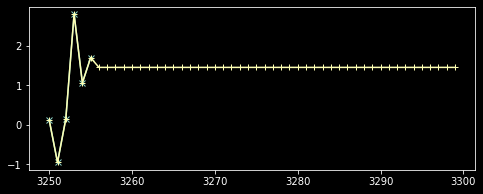

In [119]:
# Detailed view
idxSet=range(3250,3300)
_,ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 3)) # 
ax.plot(data_1['ts_id'].iloc[idxSet],data_1['feature_7'].iloc[idxSet],marker='x')
ax.plot(data_1_fill['ts_id'].iloc[idxSet],data_1_fill['feature_7'].iloc[idxSet],marker='+');

#### 1.1.2 Fill nan

In [120]:
def fillNanWithinDay(df,dayCol,fillCol,spanFillNa=1):
    """fill NaN within date
    
    This function does (forward) fill without crossing dates. Equal value in dayCol column indicates same date.
    "Date" here can be generalized to block with equal dayCol value
    Parameter:
      df: dataframe
      dayCol: string, column name. Equal value indicates same date (block)
      fillCol: list of straings, names of columns to fill NaN
      spanFillNa: integer. Using a trailing ema Of given span to fill NaN. spanFillNa=1 is equivalent to ffill
    return:
      list of pd.DataFrame of day, NaN replaced
    """
    dfList=[]
    dayList=df[dayCol].unique()
    for day in dayList:
        data_1=df.loc[data['date']==day]
        data_1_=data_1[fillCol].ewm(span=spanFillNa).mean()
        data_1_fill=data_1.copy()
        for cname in fillCol:
            toFill=data_1[cname].isna()
            data_1_fill.loc[toFill,cname]=data_1_.loc[toFill,cname]
        dfList.append(data_1_fill)
    
    return dfList
    
def splitTvBlock(dataBlock,trRatio=0.8,randSeed=None):
    """Train-validation split, by block
    
    Arguments:
        dataBlock: list of DataFrame, whcih 
        trRaio: ratio goes into training set
        randSeed: if None, no random shuffle;
    """
    nBlock=len(dataBlock)
    if randSeed is None:
        idxPerm=np.arange(nBlock)
    else:
        np.random.seed(randSeed)
        idxPerm=np.random.permutation(nBlock)
    nTrain=round(nBlock*trRatio)
        
    return pd.concat(dataBlock[:nTrain]), pd.concat(dataBlock[nTrain:])


In [121]:
# Fill NaN after first data points
fillCol=[f'feature_{ii}' for ii in range(nFeat) if ii not in [0,64]] # features to fill nan
dataBlock=fillNanWithinDay(data,'date',fillCol,spanFillNa=3)

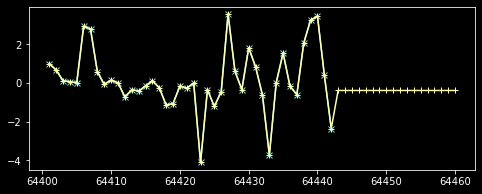

In [140]:
# Detailed view
day=10
idxSet=range(2200,2260)
_,ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 3)) # 
ax.plot(data.loc[data['date']==day,'ts_id'].iloc[idxSet],data.loc[data['date']==day,'feature_7'].iloc[idxSet],marker='x')
ax.plot(dataBlock[day]['ts_id'].iloc[idxSet],dataBlock[day]['feature_7'].iloc[idxSet],marker='+');

In [147]:
# Drop NaN at the begining of days
featName=[f'feature_{n}' for n in range(130)]
xywCol=featName+['resp','weight']
dataBlock=[data_1.loc[~data_1[xywCol].isna().any(axis=1)] for data_1 in dataBlock]


### 1.2 Train-validation-test (TVT) split

Split will be performed in the following way
 - Split is performed on dates
 - Reserve a latest segment of days as test
 - Train-validation split is randomized selection of days
 - In training and validation, each row is considered independent

Original=2390491, now=2147102, nan #rows dropped=243389


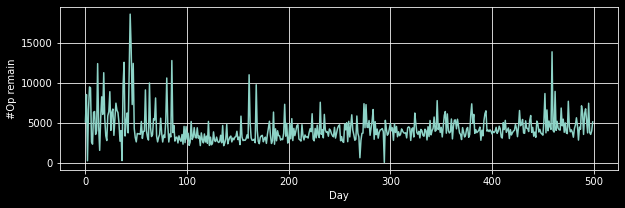

In [148]:
_, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 3))
ax.plot([len(dataBlock_1) for dataBlock_1 in dataBlock]); ax.grid()
ax.set(xlabel='Day',ylabel='#Op remain');

nTotal=np.array([blk.shape[0] for blk in dataBlock]).sum()
print('Original={:d}, now={:d}, nan #rows dropped={:d}'.format(data.shape[0],nTotal,data.shape[0]-nTotal))

In [154]:
# 1.2 TVT split
nTest_s=451 # test starting index
data_c=pd.concat(dataBlock[nTest_s:]) # test set (checking)

data_t,data_v=splitTvBlock(dataBlock[:nTest_s],trRatio=0.8,randSeed=2)
print(f'#train={data_t.shape[0]}, #validation={data_v.shape[0]}, #train={data_c.shape[0]}')

# Reformating

data_t={'X':data_t[featName], 'y':data_t['resp'], 'w':data_t['weight']}
data_v={'X':data_v[featName], 'y':data_v['resp'], 'w':data_v['weight']}
data_c={'X':data_c[featName], 'y':data_c['resp'], 'w':data_c['weight']}
print('#Nan in train: {:d}, {:d}, {:d}'.format(data_t['X'].isna().to_numpy().sum(),data_t['y'].isna().to_numpy().sum(),
                                               data_t['w'].isna().to_numpy().sum()))
print('#Nan in validation: {:d}, {:d}, {:d}'.format(data_v['X'].isna().to_numpy().sum(),data_v['y'].isna().to_numpy().sum(),
                                               data_v['w'].isna().to_numpy().sum()))
print('#Nan in test: {:d}, {:d}, {:d}'.format(data_c['X'].isna().to_numpy().sum(),data_c['y'].isna().to_numpy().sum(),
                                               data_c['w'].isna().to_numpy().sum()))

#train=1517147, #validation=382197, #train=247758
#Nan in train: 0, 0, 0
#Nan in validation: 0, 0, 0
#Nan in test: 0, 0, 0


### 1.3 Centering and scaling

Centering and scaling is done on train set. Same scheme is applied to validation and test sets.
 - Feature 0 and 64 is not scaled


In [181]:
# Normalization
featToNorm=[f'feature_{ii}' for ii in range(nFeat) if ii not in [0,64]]
norm=pd.DataFrame({'c':pd.Series(0,index=featName), 's':pd.Series(1,index=featName) }).T
norm.loc['c',featToNorm]=data_t['X'][featToNorm].mean()
norm.loc['s',featToNorm]=data_t['X'][featToNorm].std()

data_t['X']=(data_t['X']-norm.loc['c'])/norm.loc['s']
data_v['X']=(data_v['X']-norm.loc['c'])/norm.loc['s']


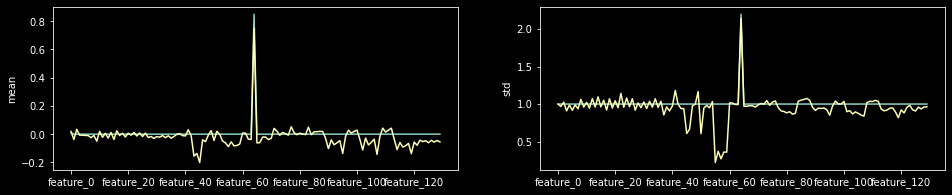

In [190]:
# Verify proper normaliation
_, axs = plt.subplots(nrows=1, ncols=2,figsize=(16, 3))
data_t['X'].mean().plot(ax=axs[0])
data_v['X'].mean().plot(ax=axs[0])
axs[0].set(ylabel='mean')
data_t['X'].std().plot(ax=axs[1])
data_v['X'].std().plot(ax=axs[1])
axs[1].set(ylabel='std');

## 2. Traing MLP

In [196]:
model = keras.Sequential(
    [
        keras.Input(shape=(nFeat,)),
        layers.Dense(256, activation="relu", name="layer1"),
        layers.Dense(64, activation="relu", name="layer2"),
        layers.Dense(32, activation="relu", name="layer3"),
        layers.Dense(128, activation="relu", name="layer4"),
        layers.Dense(64, activation="relu", name="layer5"),
        layers.Dense(1, activation="sigmoid", name="out"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 256)               33536     
_________________________________________________________________
layer2 (Dense)               (None, 64)                16448     
_________________________________________________________________
layer3 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer4 (Dense)               (None, 128)               4224      
_________________________________________________________________
layer5 (Dense)               (None, 64)                8256      
_________________________________________________________________
out (Dense)                  (None, 1)                 65        
Total params: 64,609
Trainable params: 64,609
Non-trainable params: 0
__________________________________________________

In [25]:
dayList=data['date'].unique()

In [193]:
tf.__version__

'2.2.0'